# Libraries

In [213]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow


from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score


# Defining Data Paths


In [214]:
train_path = r"/Users/hilalscomputer/Desktop/VGG19-Binamod-Model/dataset/train"
test_path = r"/Users/hilalscomputer/Desktop/VGG19-Binamod-Model/dataset/test"
val_path = r"/Users/hilalscomputer/Desktop/VGG19-Binamod-Model/dataset/val"

In [215]:
# Görseli yükleyip görselleştirme fonksiyonu
def show_images_from_folder(folder_path, num_images=2):
    for folder in os.listdir(folder_path):
        sub_path = os.path.join(folder_path, folder)

        if folder == '.DS_Store':
            continue

        print(folder)
        for i in range(min(num_images, len(os.listdir(sub_path)))):
            temp_path = os.path.join(sub_path, os.listdir(sub_path)[i])
            img = mpimg.imread(temp_path)
            plt.imshow(img)
            plt.show()
    

# Converting image to pixel

In [216]:
# Görsel dizisini oluşturma fonksiyonu
def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path = os.path.join(path, folder)

        if folder == '.DS_Store':
            continue

        for img in os.listdir(sub_path):
            image_path = os.path.join(sub_path, img)
            img_arr = cv2.imread(image_path)
            img_arr = cv2.resize(img_arr, size)
            data.append(img_arr)
            
    return data


In [217]:
# Görselleri yükle
size = (250, 250)

In [218]:
%%time
train = imagearray(train_path, size)
test = imagearray(test_path, size)
val = imagearray(val_path, size)

CPU times: user 2.48 s, sys: 184 ms, total: 2.66 s
Wall time: 2.94 s


# Normalization

In [219]:
x_train = np.array(train) / 255.0
x_test = np.array(test) / 255.0
x_val = np.array(val) / 255.0


# Defining target variables

In [220]:
# ImageDataGenerator ile veri sınıflandırma
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale=1./255)
    classes = datagen.flow_from_directory(
        data_path,
        target_size=size,
        batch_size=32,
        class_mode=class_mode
    )
    return classes

In [221]:
train_class = data_class(train_path, size, "sparse")
test_class = data_class(test_path, size, "sparse")
val_class = data_class(val_path, size, "sparse")

Found 27 images belonging to 3 classes.
Found 13 images belonging to 3 classes.
Found 1 images belonging to 1 classes.


In [222]:
y_train = train_class.classes
y_test = test_class.classes
y_val = val_class.classes

In [223]:
train_class.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2,
       2, 2, 2, 2, 2], dtype=int32)

In [224]:
train_class.class_indices

{'damage_type_a': 0, 'damage_type_b': 1, 'damage_type_c': 2}

In [225]:
# Eğitim ve doğrulama veri setlerinin boyutlarının eşit olduğu durum
if len(x_val) != len(y_val):
    print("x_val ve y_val veri setleri aynı boyutta değil! Düzeltiliyor...")
    if len(y_val) < len(x_val):
        y_val = np.concatenate([y_val, np.random.randint(0, len(np.unique(y_train)), size=(len(x_val) - len(y_val)))])
    elif len(y_val) > len(x_val):
        y_val = y_val[:len(x_val)]
    print("Düzeltilmiş y_val shape:", y_val.shape)


# VGG19 Model

In [226]:
vgg = VGG19(input_shape = (250, 250, 3), weights = "imagenet", include_top = False)

In [227]:
for layer in vgg.layers:
    layer.trainable = False

In [228]:
x = Flatten()(vgg.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)  # Dropout ekleme
prediction = Dense(len(np.unique(y_train)), activation="softmax")(x)  # Sınıf sayısına göre doğru sayıda nöron


In [229]:
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0   

In [230]:
plot_model(model = model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [231]:
early_stop = EarlyStopping(monitor="val_loss", mode = "min", verbose = 1, patience = 5)

In [232]:
model.compile(loss =  "sparse_categorical_crossentropy", 
              optimizer = "adam",
              metrics = ["accuracy"])

In [233]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    callbacks=[early_stop],
    batch_size=30,
    shuffle=True
)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 1.7587 - accuracy: 0.1111 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 9.3201 - accuracy: 0.6667 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 6.5291 - accuracy: 0.6667 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 1.6965 - accuracy: 0.7407 - val_loss: 5.8019 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 1.2757 - accuracy: 0.6296 - val_loss: 8.2503 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 1.0568 - accuracy: 0.5556 - val_loss: 7.6394 - val_accuracy: 0.0000e+00
Epoch 6: early stopping


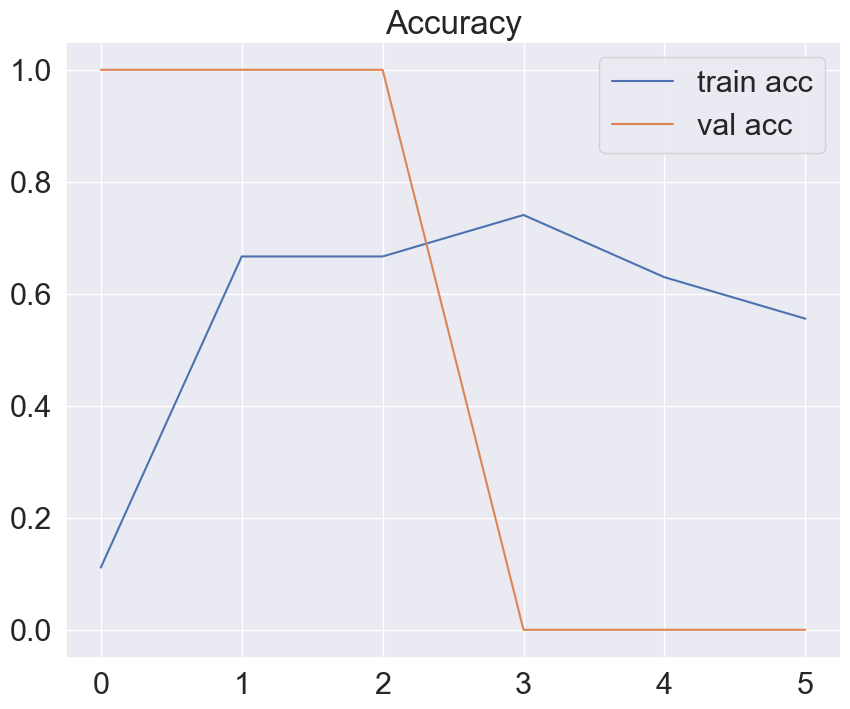

In [234]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["accuracy"], label = "train acc")
plt.plot(history.history["val_accuracy"], label = "val acc")
plt.legend()
plt.title("Accuracy")
plt.show()

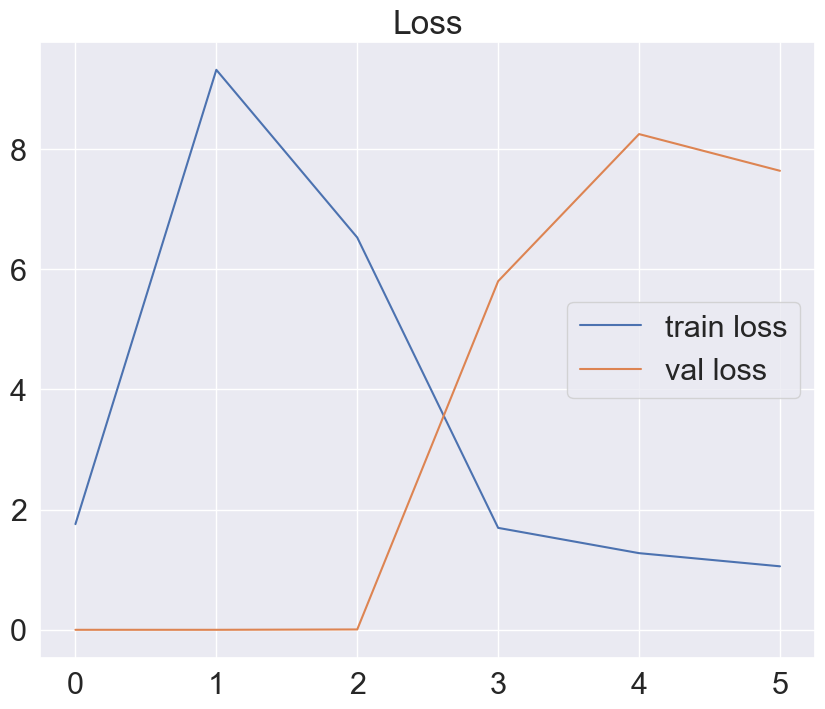

In [235]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "val loss")
plt.legend()
plt.title("Loss")
plt.show()

# Model Evulation

In [236]:
model.evaluate(x_test, y_test, batch_size = 32)

1/1 [==============================] - 2s 2s/step - loss: 0.5002 - accuracy: 0.8462


[0.5002471804618835, 0.8461538553237915]

In [237]:
y_pred = model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [238]:
y_pred = np.argmax(y_pred, axis=1)

In [239]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.00      0.00      0.00         0
           2       0.75      0.75      0.75         4

    accuracy                           0.85        13
   macro avg       0.58      0.55      0.56        13
weighted avg       0.92      0.85      0.88        13



/Users/hilalscomputer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hilalscomputer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hilalscomputer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion Matrix

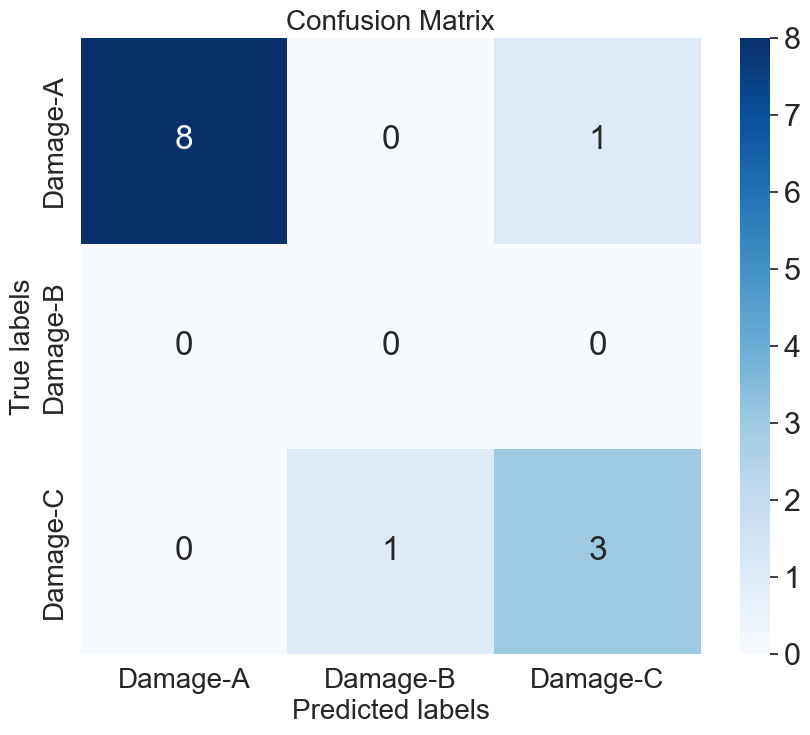

In [240]:
cm = confusion_matrix(y_pred,y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20);ax.set_ylabel('True labels', fontsize=20); 
ax.set_title('Confusion Matrix', fontsize=20); 
ax.xaxis.set_ticklabels(['Damage-A', 'Damage-B', 'Damage-C'], fontsize=20); ax.yaxis.set_ticklabels(['Damage-A', 'Damage-B', 'Damage-C'], fontsize=20);

In [241]:
f1_score(y_test, y_pred , average="micro")

0.8461538461538461

In [242]:
recall_score(y_test, y_pred, average="weighted")

0.8461538461538461

In [243]:
precision_score(y_test, y_pred, average="micro")

0.8461538461538461

# Saving Model

In [244]:
model.save("/Users/hilalscomputer/Desktop/Binamod-Intership-2024/VGG19-Model")

2024-07-22 17:23:20.639254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2024-07-22 17:23:21.110066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: /Users/hilalscomputer/Desktop/Binamod-Intership-2024/VGG19-Model/assets


INFO:tensorflow:Assets written to: /Users/hilalscomputer/Desktop/Binamod-Intership-2024/VGG19-Model/assets
